In [91]:
from cmath import inf
import os
import random
import argparse
from random import shuffle
from re import T
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from torchsummary import summary

from RIDNET import RIDNet
from Loaders import get_val_loader, get_train_loader

from losses import *

from Metrics import PSNR


<h2 style="background-color:#A8F4FF;font-family:Serif;font-size:200%;color: #000;text-align:center;border-radius: 50px 50px;">  Validation</h2>

In [78]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.cuda.manual_seed_all(seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

In [90]:
# L'index de similarité structurelle (SSIM) est une mesure utilisée pour évaluer la similarité entre deux images.
def SSIM(img1, img2, C1=0.01, C2=0.03):
    # Mean of img1 and img2
    mu1 = img1.mean()
    mu2 = img2.mean()

    # Variance of img1 and img2
    sigma1_sq = ((img1 - mu1) * (img1 - mu1)).mean()
    sigma2_sq = ((img2 - mu2) * (img2 - mu2)).mean()

    # Covariance of img1 and img2
    sigma12 = ((img1 - mu1) * (img2 - mu2)).mean()

    # Constants
    L = 1  # Dynamic range of pixel values
    C1 = (C1 * L) ** 2
    C2 = (C2 * L) ** 2

    # SSIM formula
    ssim_val = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_val.item()

In [79]:
def myModel(path):
    weight_folder = 'weight'
    model_path = os.path.join(weight_folder, path)
    checkpoint = torch.load(model_path)
    model = RIDNet(in_channels=3, num_features=128)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def apply_random_noise(clean_image):
    noise_type = np.random.choice(['gaussian', 'salt_pepper', 'poisson'])

    if noise_type == 'gaussian':
        noisy_image = gaussian_noise(clean_image)
    elif noise_type == 'salt_pepper':
        noisy_image = salt_pepper_noise(clean_image)
    else:
        noisy_image = poisson_noise(clean_image)

    return noisy_image

def gaussian_noise(img, noise_level=[15, 25, 50]):
    sigma = np.random.choice(noise_level, size=(1, 1, 3))
    sigma *= 3 
    gaussian_noise = np.random.normal(0, sigma, img.shape)

    noisy_img = img + gaussian_noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)

    return noisy_img

def salt_pepper_noise(image, amount=0.05):
    noisy_image = np.copy(image)
    num_salt = np.ceil(amount * image.size * 0.5)
    num_pepper = np.ceil(amount * image.size * 0.5)

    # Générer des coordonnées pour le sel
    salt_coords = [np.random.randint(0, d - 1, int(num_salt)) for d in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 1

    # Générer des coordonnées pour le poivre
    pepper_coords = [np.random.randint(0, d - 1, int(num_pepper)) for d in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image

def poisson_noise(image, scale=0.005):
    noisy_image = np.random.poisson(image * scale) / scale
    return noisy_image

def Transformation(img_path):
    img = glob.glob(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img.copy()).type(torch.float32)
    # (H, W, C) -> (C, H, W)
    img = img.permute(2, 0, 1)
    img = img / 255.

    return img



In [80]:
def test_image(model,image_path):
    # Charger l'image
    clean_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    clean_image = cv2.cvtColor(clean_image, cv2.COLOR_BGR2RGB)

    # Appliquer les mêmes transformations
    noisy_image = apply_random_noise(clean_image)

    # Assurez-vous que l'image est sur le bon appareil (CPU/GPU) pour la prédiction
    noisy_image_tensor = torch.from_numpy(noisy_image).permute(2, 0, 1).unsqueeze(0).float()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    noisy_image_tensor = noisy_image_tensor / 255
    noisy_image_tensor = noisy_image_tensor.to(device)

 
    # Effectuer la prédiction avec votre modèle déjà initialisé et chargé
    with torch.no_grad():
        output = model(noisy_image_tensor)
        output = output.cpu().squeeze(0).permute(1, 2, 0)

    # Visualiser les images
    plt.figure(figsize=(8, 4))

    # Affichage de l'image originale
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(clean_image)
    plt.axis('off')

    # Affichage de l'image bruitée
    plt.subplot(1, 3, 2)
    plt.title('Noisy Image')
    plt.imshow(noisy_image)
    plt.axis('off')

    # Affichage de l'image prédite
    plt.subplot(1, 3, 3)
    plt.title('Predicted Image')
    plt.imshow(output)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


<h4 style="background-color:#A8F4FF;font-family:Serif;font-size:200%;color: #000;text-align:center;border-radius: 50px 50px;"> Validation of First Training</h4>

First Metric:Peak Signal-to-Noise Ratio (PSNR) est une mesure de qualité d'image qui compare la qualité d'une image originale et celle d'une image dégradée, exprimé en décibels (dB).</br>
<img src="psnr.png"/>

Second Metric:L'index de similarité structurelle (SSIM) est une mesure utilisée pour évaluer la similarité entre deux images.
<img src="ssim.png"/>

In [95]:
psnr_metrics = []
ssim_metrics = []
val = []
val_losses= 0.
def evaluation(batch_size):
    
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print(device)
        # Autres opérations à effectuer sur GPU ici...
    else:
        device = torch.device('cpu')
        print("CUDA n'est pas disponible, utilisation de CPU.")
        
    weight_folder = 'weight'
    model_path = os.path.join(weight_folder, 'best_model.pth')
    checkpoint = torch.load(model_path)
    model = RIDNet(in_channels=3, num_features=128)
    model.load_state_dict(checkpoint['model_state_dict'])
    criterion = checkpoint['loss']

    val_loader = get_val_loader(dataset_path="./val_data", batch_size=batch_size)

    model.eval()
    with torch.no_grad():
        val_loss = 0.
        loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)

        for j, data in loop:
            noisy = data['noisy'].to(device)
            clean = data['clean'].to(device)

            pred = model(noisy)
            
            loss = criterion(pred, clean)
            val_loss += loss.item()
            loop.set_description(f'valid')

            psnr = PSNR(pred, clean)
            ssim = SSIM(pred, clean)

            psnr_metrics.append(psnr)
            ssim_metrics.append(ssim)
            val.append(loss.item())

            print(f'Step {j+1},Loss: {loss.item():.8f} PSNR: {psnr:.8f}, SSIM: {ssim:.8f}')
    
   
    val_losses = val_loss / len(val_loader)


In [96]:
if __name__ == '__main__':
    seed_everything(42)
    evaluation(2)

CUDA n'est pas disponible, utilisation de CPU.


valid:  20%|██        | 1/5 [00:51<03:24, 51.01s/it]

Step 1,Loss: 123.39328766 PSNR: 20.58293152, SSIM: 0.47305274


valid:  40%|████      | 2/5 [01:41<02:32, 50.99s/it]

Step 2,Loss: 146.64553833 PSNR: 20.27008820, SSIM: 0.40667278


valid:  60%|██████    | 3/5 [02:33<01:42, 51.19s/it]

Step 3,Loss: 68.22487640 PSNR: 22.63529587, SSIM: 0.47452101


valid:  80%|████████  | 4/5 [03:24<00:51, 51.04s/it]

Step 4,Loss: 63.01657104 PSNR: 22.77777100, SSIM: 0.48761159


Step 5,Loss: 64.81877136 PSNR: 22.90990829, SSIM: 0.56642151


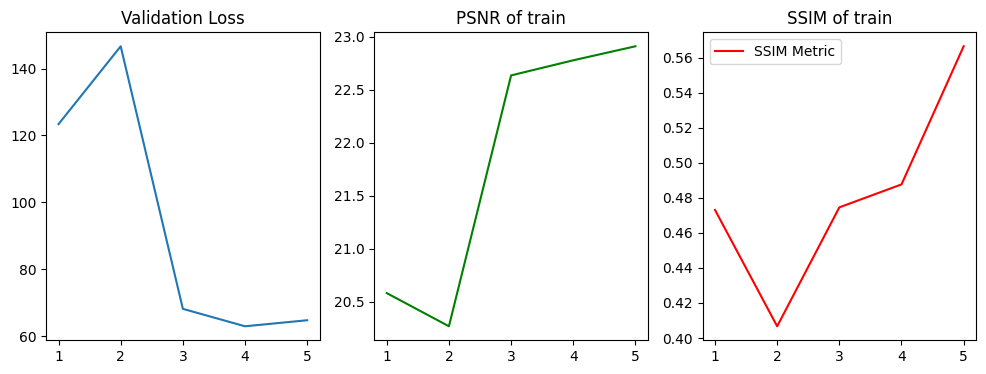

In [99]:
# Affichage des courbes de perte
plt.figure(figsize=(12, 4))
step = range(1, 6)
# Affichage de l'image originale
plt.subplot(1, 3, 1)
plt.title('Validation of train')
plt.plot(step,val, label='Validation Loss')
plt.title('Validation Loss')

plt.subplot(1,3,2)
plt.plot(step,psnr_metrics, label='PSNR Metric', color='green')
plt.title('PSNR of train')

plt.subplot(1,3,3)
plt.plot(step,ssim_metrics, label='SSIM Metric', color='red')
plt.title('SSIM of train')
plt.legend()
plt.show()

## Visualisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


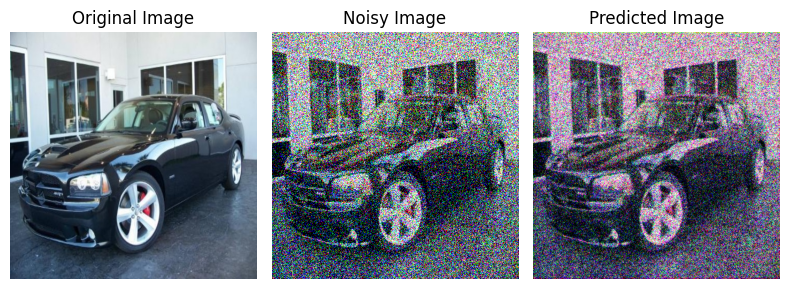

In [66]:
model = myModel('best_model.pth')
test_image(model,'./test/image0037.jpg')

<h4 style="background-color:#A8F4FF;font-family:Serif;font-size:200%;color: #000;text-align:center;border-radius: 50px 50px;"> Validation of Train Continuous Model</h4>

In [100]:
psnr_metrics_cont = []
ssim_metrics_cont = []

val_cont = []
val_losses_cont= 0.
def evaluation(batch_size):
    
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print(device)
        # Autres opérations à effectuer sur GPU ici...
    else:
        device = torch.device('cpu')
        print("CUDA n'est pas disponible, utilisation de CPU.")
        
    weight_folder = 'weight'
    model_path = os.path.join(weight_folder, 'best_model_continuous.pth')
    checkpoint = torch.load(model_path)
    model = RIDNet(in_channels=3, num_features=128)
    model.load_state_dict(checkpoint['model_state_dict'])
    criterion = checkpoint['loss']

    val_loader = get_val_loader(dataset_path="./val_data", batch_size=batch_size)

    model.eval()
    with torch.no_grad():
        val_loss = 0.
        loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)

        for j, data in loop:
            noisy = data['noisy'].to(device)
            clean = data['clean'].to(device)

            pred = model(noisy)
            
            loss = criterion(pred, clean)
            val_loss += loss.item()
            loop.set_description(f'valid')

            psnr = PSNR(pred, clean)
            
            ssim = SSIM(pred, clean)

            psnr_metrics_cont.append(psnr)
            ssim_metrics_cont.append(ssim)
            val_cont.append(loss.item())

            print(f'Step {j+1},Loss: {loss.item():.8f} PSNR: {psnr:.8f}, SSIM: {ssim:.8f}')
    
   
    val_losses_cont = val_loss / len(val_loader)


In [101]:
if __name__ == '__main__':
    seed_everything(42)
    evaluation(2)

CUDA n'est pas disponible, utilisation de CPU.


valid:  20%|██        | 1/5 [00:53<03:35, 53.85s/it]

Step 1,Loss: 0.26383671 PSNR: 20.25328445, SSIM: 0.48919013


valid:  40%|████      | 2/5 [01:48<02:43, 54.54s/it]

Step 2,Loss: 0.30425555 PSNR: 19.59569931, SSIM: 0.42651382


valid:  60%|██████    | 3/5 [02:44<01:50, 55.25s/it]

Step 3,Loss: 0.16223186 PSNR: 21.64023399, SSIM: 0.49075991


valid:  80%|████████  | 4/5 [03:36<00:53, 53.82s/it]

Step 4,Loss: 0.15463690 PSNR: 21.89372063, SSIM: 0.50289524


Step 5,Loss: 0.15922037 PSNR: 22.72623444, SSIM: 0.57943660


### Visuation

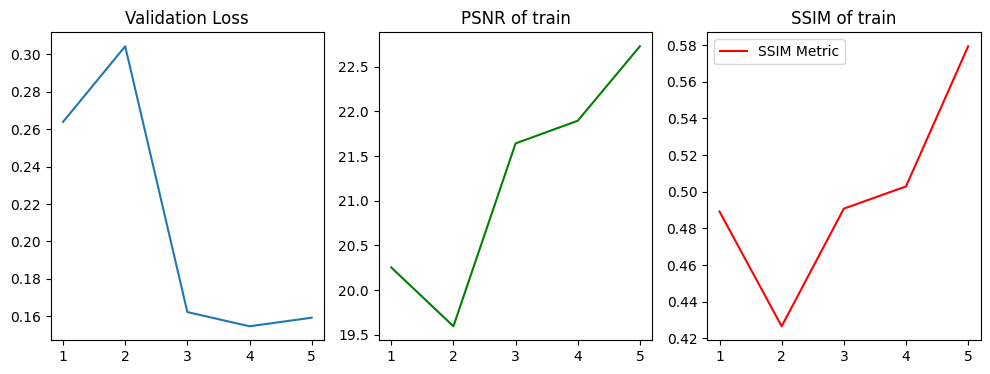

In [102]:
# Affichage des courbes de perte
plt.figure(figsize=(12, 4))
step = range(1, 6)
# Affichage de l'image originale
plt.subplot(1, 3, 1)
plt.title('Validation of train')
plt.plot(step,val_cont, label='Validation Loss')
plt.title('Validation Loss')

plt.subplot(1,3,2)
plt.plot(step,psnr_metrics_cont, label='PSNR Metric', color='green')
plt.title('PSNR of train')

plt.subplot(1,3,3)
plt.plot(step,ssim_metrics_cont, label='SSIM Metric', color='red')
plt.title('SSIM of train')
plt.legend()
plt.show()

## Plotting

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


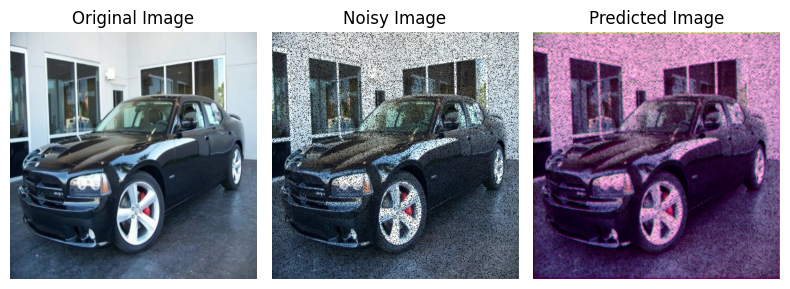

In [60]:
model = myModel('best_model_continuous.pth')
test_image(model, './test/image0037.jpg')